In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import wcs
from astropy.io import fits

In [2]:
def load_cat(filename):

    return pd.read_csv(filename, sep=r'\s+', skiprows=5, header=None, names=["ra", "dec",
            "flux", "flux_err"])

def plot_galaxy():
    
    plt.imshow(imageB[675:925, 325:825], cmap="magma", vmin=0.045, vmax=0.05)
    plt.colorbar()

In [3]:
hdulB = fits.open("data/B_stacked.fits")
hduB = hdulB[0]
imageB = hduB.data.T

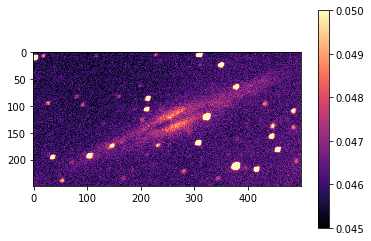

In [4]:
plot_galaxy()

In [5]:
cat = load_cat("data/B_gal.cat")
cat.sort_values(by="flux", ascending=False, inplace=True)

In [6]:
w = wcs.WCS(hduB.header)

In [7]:
starwcs = np.stack((cat["ra"], cat["dec"])).T

In [8]:
starpix = w.wcs_world2pix(starwcs, 0)

In [9]:
indx = np.indices(imageB.shape)
pix = np.stack((indx[0].flatten(), indx[1].flatten())).T

In [10]:
for pair in starpix:
    
    dist = np.sqrt(((pix - pair)**2).sum(axis=1))
    inradius = pix[dist < 9.6].T
    imageB[inradius[0], inradius[1]] = 0.0

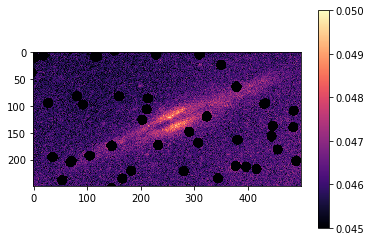

In [11]:
plot_galaxy()

In [12]:
def parx(t, x0, y0, a, b, theta):
    
    return a*np.cos(t)*np.cos(theta) - b*np.sin(t)*np.sin(theta) + x0

def pary(t, x0, y0, a, b, theta):
    
    return a*np.cos(t)*np.sin(theta) + b*np.sin(t)*np.cos(theta) + y0

def plot_ellipse(x0, y0, a, b, theta):
    
    t = np.linspace(0, 2*np.pi)
    x = parx(t, x0, y0, a, b, theta)
    y = pary(t, x0, y0, a, b, theta)
    plt.plot(x, y, color="deepskyblue")

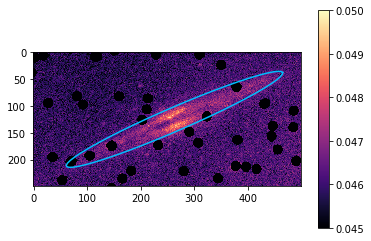

In [13]:
plot_galaxy()
x0, y0, a, b, theta = 263, 125, 220, 22, -0.13 * np.pi
plot_ellipse(x0, y0, a, b, theta)

In [14]:
A = (np.cos(theta)/a)**2 + (np.sin(theta)/b)**2
B = 2*np.cos(theta)*np.sin(theta)*(1/a**2 - 1/b**2)
C = (np.sin(theta)/a)**2 + (np.cos(theta)/b)**2

def x_y(y):
    
    y -= y0
    D = B*y
    E = C*y**2 - 1
    desc = D**2 - 4*A*E
    if desc < 0: return None
    x1 = (-D - np.sqrt(desc)) / A + x0
    x2 = (-D + np.sqrt(desc)) / A + x0
    return x1, x2

def y_x(x):
    
    x -= x0
    D = B*x
    E = A*x**2 - 1
    desc = D**2 - 4*C*E
    if desc < 0: return None
    y1 = (-D - np.sqrt(desc)) / C + y0
    y2 = (-D + np.sqrt(desc)) / C + y0
    return y1, y2

def inside_ellipse_old(x, y):
    
    inside = True
    
    try:
        x1, x2 = x_y(y)
        y1, y2 = y_x(x)
    except TypeError:
        return False
    
    inside &= x1 <= x <= x2
    inside &= y1 <= y <= y2
    return inside

def inside_ellipse(x, y):
    
    t = np.linspace(0, 2*np.pi, num=10000)
    x_t = parx(t, x0, y0, a, b, theta)
    y_t = pary(t, x0, y0, a, b, theta)
    
    dx = np.abs(x_t - x)
    dy = np.abs(y_t - y)
    
    i1 = np.argmin(dx)
    j1 = np.argmin(dy)
    
    dx[i1] = float("inf")
    dy[j1] = float("inf")
    
    i2 = np.argmin(dx)
    j2 = np.argmin(dy)
    
    x1, x2 = sorted([x_t[j1], x_t[j2]])
    y1, y2 = sorted([y_t[i1], y_t[i2]])
    
    inside  = x1 <= x <= x2
    inside &= y1 <= y <= y2
    return inside

In [15]:
x = pix.T[1].reshape(imageB.shape)[675:925, 325:825] - 325
y = pix.T[0].reshape(imageB.shape)[675:925, 325:825] - 675
y = y[::-1]

In [16]:
def indices_in_ellipse(x, y):
    
    imax, jmax = x.shape

    for i in range(imax):
        for j in range(jmax):
            if inside_ellipse(x[i][j], y[i][j]):
                yield i, j

In [17]:
ind_dim1, ind_dim2 = np.array(list(indices_in_ellipse(x, y))).T

In [18]:
fluxB = imageB[ind_dim1, ind_dim2].sum()
fluxB

381.38477